In [1]:
GALAXY = 'ngc6822'
GALAXYFULLNAME = 'ngc6822'
USER = 'enk'
PREFIX = '/raid/pfs'
USEPMAP = False

#date of observation
YEAR = 2025
MONTH = 7
DAY = 1

OBS_PATH = f'{PREFIX}/data/cmdfit/dSph'
HSC_FILE = f'{PREFIX}/data/cmdfit/dSph/{GALAXY}_tpall3e_g24.cat'
GAIA_FILE = f'{PREFIX}/data/cmdfit/dSph/gaia.h5'
SKY_FILE = f'{PREFIX}/data/cmdfit/dSph/sky_{GALAXYFULLNAME}.feather'
FLUXSTD_FILE = f'{PREFIX}/data/cmdfit/dSph/fluxstd_{GALAXYFULLNAME}.feather'
MLCLASS_FILE = f'{PREFIX}/data/targeting/dSph/{GALAXY}/{GALAXYFULLNAME}_mlclass.csv'
PMAP_FILE = f'{PREFIX}/data/cmdfit/run/{GALAXY}/sim/nobin_chab_nb_250k_001/pmap.h5'
OUTPUT_PATH = f'{PREFIX}/user/{USER}/netflow'
ISOCHRONES_PATH = f'{PREFIX}/data/cmdfit/isochrones/dartmouth/import/afep0_cfht_sdss_hsc'

GAIA_CROSSMATCH_RADIUS = 0.1    # in arcsec

NVISITS = 1
OUTPUT_PATH = f'{PREFIX}/user/{USER}/netflow/{GALAXY}_{NVISITS}_visit'

In [2]:
import os, sys
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Ellipse, Circle
from matplotlib.gridspec import GridSpec
from scipy.special import logsumexp
from scipy.interpolate import interp1d

from astropy import wcs
from astropy import units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.time import Time

In [3]:
plt.rc('font', size=6) #controls default text size

if 'debug' not in globals():
    import debugpy
    debugpy.listen(('0.0.0.0', 5698))
    debug = True

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

# Compile data

## Plot definitions

In [6]:
import pfs.utils
from pfs.ga.targeting.targets.dsph import *
from pfs.ga.targeting.instrument import *
from pfs.ga.targeting.diagram import CMD, CCD, FOV, FP, ColorAxis, MagnitudeAxis
from pfs.ga.targeting.photometry import Photometry, Magnitude, Color
from pfs.ga.targeting.projection import WcsProjection
from pfs.ga.targeting.netflow import Netflow, Pointing
from pfs.ga.targeting.io import DataFrameSerializer

2024-10-15 16:30:24.612948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 16:30:25.527851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
galaxy = GALAXIES[GALAXY]
hsc = galaxy.get_photometry()
cmd = galaxy.get_cmd()
ccd = galaxy.get_ccd()
gaia_cmd = galaxy.get_cmd(Gaia)

In [8]:
pointings = galaxy.get_pointings(SubaruPFI)
pointing = pointings[0]

for p in pointings:
    print(p.ra, p.dec, p.posang)

296.235 -14.789 30.0


In [9]:
wcs = WcsProjection(pointing, proj='TAN')
wfc = SubaruWFC(pointing)
fov = FOV(projection=wcs)
fp = FP(wfc)

## Load isochrones

In [10]:
from pfs.ga.isochrones.isogrid import IsoGrid

In [11]:
iso = IsoGrid()
iso.load(os.path.join(ISOCHRONES_PATH, 'isochrones.h5'))

2024-10-15 16:30:27.704536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1592 MB memory:  -> device: 0, name: Quadro P1000, pci bus id: 0000:65:00.0, compute capability: 6.1


In [12]:
iso.values.keys()

dict_keys(['M_ini', 'cfht_g', 'cfht_i', 'cfht_r', 'cfht_u', 'hsc_g', 'hsc_i', 'hsc_r', 'log_L', 'log_T_eff', 'log_g', 'sdss_g', 'sdss_i', 'sdss_r', 'sdss_u', 'sdss_z'])

## Load probability map

In [13]:
from pfs.ga.targeting import ProbabilityMap
from pfs.ga.targeting.selection import ProbabilityCut, ProbabilitySampling

In [14]:
if USEPMAP:
    pmap = ProbabilityMap(cmd.axes)
    pmap.load(PMAP_FILE)

In [15]:
if USEPMAP:
    f, axs = plt.subplots(1, 2, figsize=(6, 4), dpi=120)

    l0 = cmd.plot_probability_map(axs[0], pmap, 0)
    axs[0].set_title("non-member")

    l1 = cmd.plot_probability_map(axs[1], pmap, 1)
    axs[0].set_title("member")

    f.tight_layout()

In [16]:
if USEPMAP:
    # Define a cut based on probability

    probcut = ProbabilityCut(pmap, 1, np.log(0.001))

## Load observations

In [17]:
from pfs.ga.targeting.io import TextObservationReader
from pfs.ga.targeting.util.astro import *

In [18]:
obs = SubaruHSC.text_observation_reader().read(HSC_FILE)
obs.data.shape

(220202, 17)

In [19]:
obs.data.columns

Index(['objid', 'RA', 'Dec', 'X', 'Y', 'obs_hsc_i', 'obs_hsc_g',
       'obs_hsc_nb515', 'err_hsc_i', 'err_hsc_g', 'err_hsc_nb515', 'cli',
       'clg', 'cln', 'ext_hsc_g', 'ext_hsc_i', 'ext_hsc_nb515'],
      dtype='object')

### Plot observations with color cuts

/raid/pfs/ga_targeting/python/pfs/ga/targeting/diagram/diagram.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  l = ax.scatter(x[mask][s], y[mask][s], c=color, s=size, **style)
/raid/pfs/ga_targeting/python/pfs/ga/targeting/diagram/diagram.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  l = ax.scatter(x[mask][s], y[mask][s], c=color, s=size, **style)


Text(0.5, 0.98, 'Stars selected based on color cuts.')

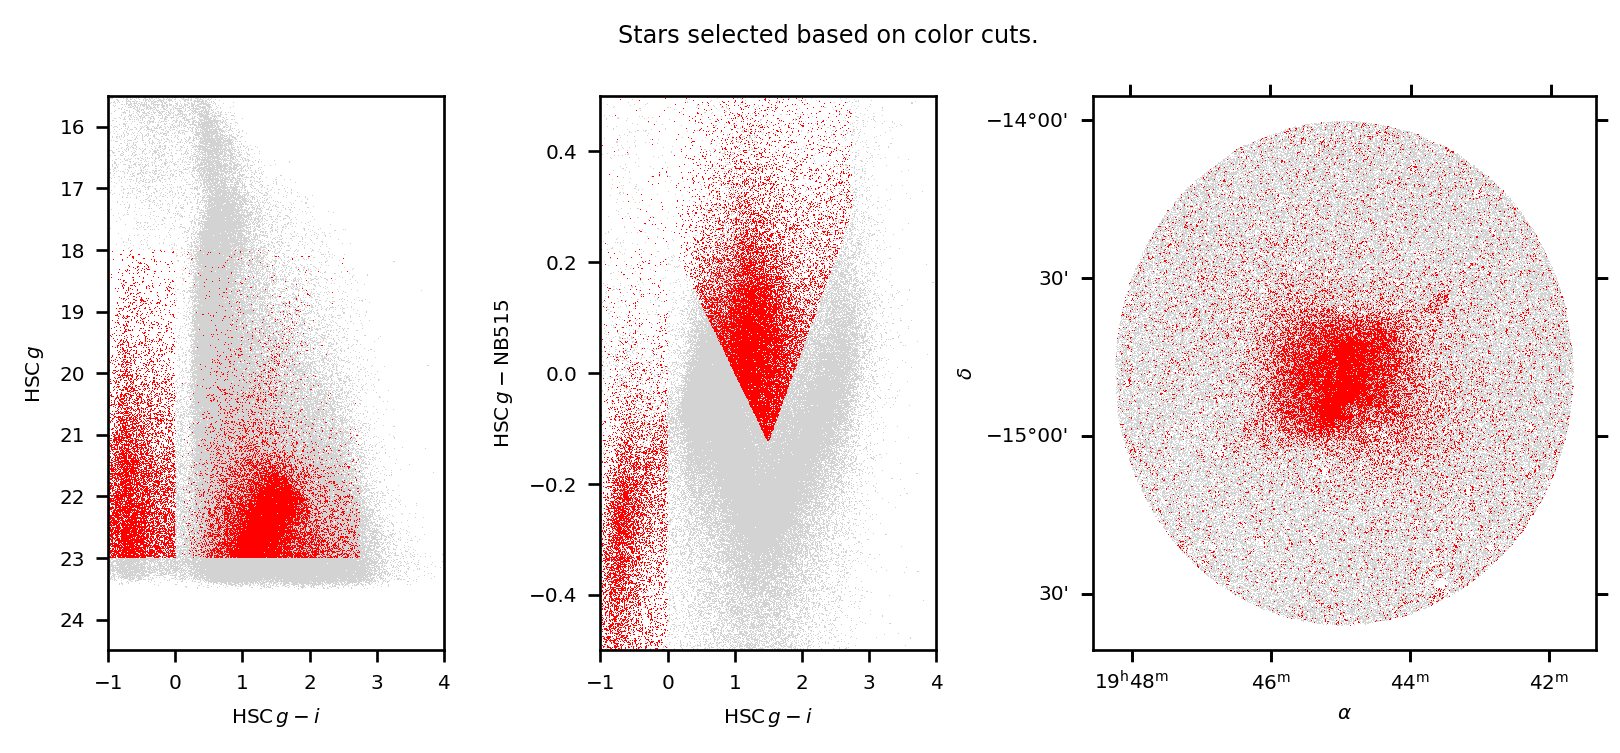

In [20]:
cmap = plt.get_cmap('tab10')

mask = galaxy.get_selection_mask(obs, nb=True)

f = plt.figure(figsize=(8, 3), dpi=240)
gs = f.add_gridspec(1, 3, width_ratios=[2, 2, 3], wspace=0.4)   

ax = f.add_subplot(gs[0])
cmd.plot_observation(ax, obs, c='lightgray')
cmd.plot_observation(ax, obs, c='r', mask=mask, cmap=cmap)

ax = f.add_subplot(gs[1])
ccd.plot_observation(ax, obs, c='lightgray')
ccd.plot_observation(ax, obs, c='r', mask=mask, cmap=cmap)

ax = f.add_subplot(gs[2], projection=wcs.wcs)
fov.plot_observation(ax, obs, c='lightgray')
fov.plot_observation(ax, obs, c='r', mask=mask, cmap=cmap)

f.suptitle('Stars selected based on color cuts.')

## Get GAIA data

In [21]:
from pfs.ga.targeting.io import Hdf5ObservationReader, Hdf5ObservationWriter, GaiaReader

In [22]:
if os.path.isfile(GAIA_FILE):
    print('GAIA data file found, read from local.')
    r = Hdf5ObservationReader()
    gaia = r.read(GAIA_FILE, GALAXY, 'gaia')
    gaia.frame = 'icrs'
    gaia.equinox = 'J2015'
    print(gaia.data.shape)
else:
    print('GAIA data file not found, running query against archive.')
    r = GaiaReader()
    gaia = r.cone_search(galaxy.pos, galaxy.rad)
    print(gaia.data.shape)

    w = Hdf5ObservationWriter()
    w.write(gaia, GAIA_FILE, GALAXY, 'gaia')

GAIA data file found, read from local.
(629175, 16)


In [23]:
gaia.data.columns

Index(['Dec', 'RA', 'SOURCE_ID', 'err_gaia_bp', 'err_gaia_g', 'err_gaia_rp',
       'err_parallax', 'err_pmdec', 'err_pmra', 'obs_gaia_bp', 'obs_gaia_g',
       'obs_gaia_rp', 'parallax', 'pm', 'pmdec', 'pmra'],
      dtype='object')

In [24]:
# Cross-match HSC with GAIA
gaia_idx, separation = obs.cross_match(gaia)
print('median separation', np.median(separation.arcsec))
hsc_gaia_mask = (separation.arcsec < GAIA_CROSSMATCH_RADIUS)
print(hsc_gaia_mask.sum())

median separation 3.237982364701124
90895


In [25]:
# Cross-match HSC with GAIA
hsc_idx, separation = gaia.cross_match(obs)
print('median separation', np.median(separation.arcsec))
gaia_hsc_mask = (separation.arcsec < GAIA_CROSSMATCH_RADIUS)
print(gaia_hsc_mask.sum())

median separation 2274.0380794211915
90894


/raid/pfs/ga_targeting/python/pfs/ga/targeting/diagram/diagram.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  l = ax.scatter(x[mask][s], y[mask][s], c=color, s=size, **style)
/raid/pfs/ga_targeting/python/pfs/ga/targeting/diagram/diagram.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  l = ax.scatter(x[mask][s], y[mask][s], c=color, s=size, **style)


Text(0.5, 0.98, 'GAIA stars with HSC counterparts within 1"')

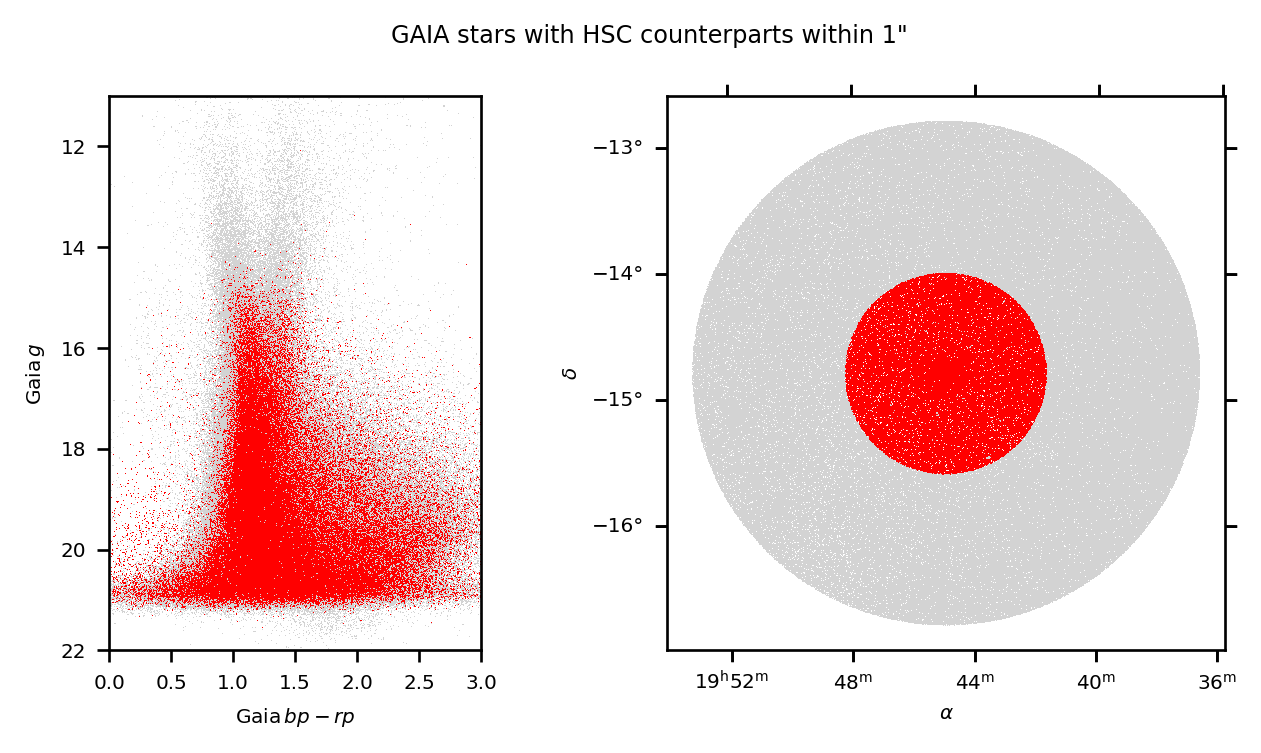

In [26]:
cmap = plt.get_cmap('tab10')

f = plt.figure(figsize=(6, 3), dpi=240)
gs = f.add_gridspec(1, 2, width_ratios=[2, 3], wspace=0.4)   

ax = f.add_subplot(gs[0])
gaia_cmd.plot_observation(ax, gaia, c='lightgray')
gaia_cmd.plot_observation(ax, gaia, c='r', mask=gaia_hsc_mask, cmap=cmap)

ax = f.add_subplot(gs[1], projection=wcs.wcs)
fov.plot_observation(ax, gaia, c='lightgray')
fov.plot_observation(ax, gaia, c='r', mask=gaia_hsc_mask, cmap=cmap)

f.suptitle('GAIA stars with HSC counterparts within 1"')

/raid/pfs/ga_targeting/python/pfs/ga/targeting/diagram/diagram.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  l = ax.scatter(x[mask][s], y[mask][s], c=color, s=size, **style)
/raid/pfs/ga_targeting/python/pfs/ga/targeting/diagram/diagram.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  l = ax.scatter(x[mask][s], y[mask][s], c=color, s=size, **style)


Text(0.5, 0.98, 'HSC stars with GAIA counterparts within 1"')

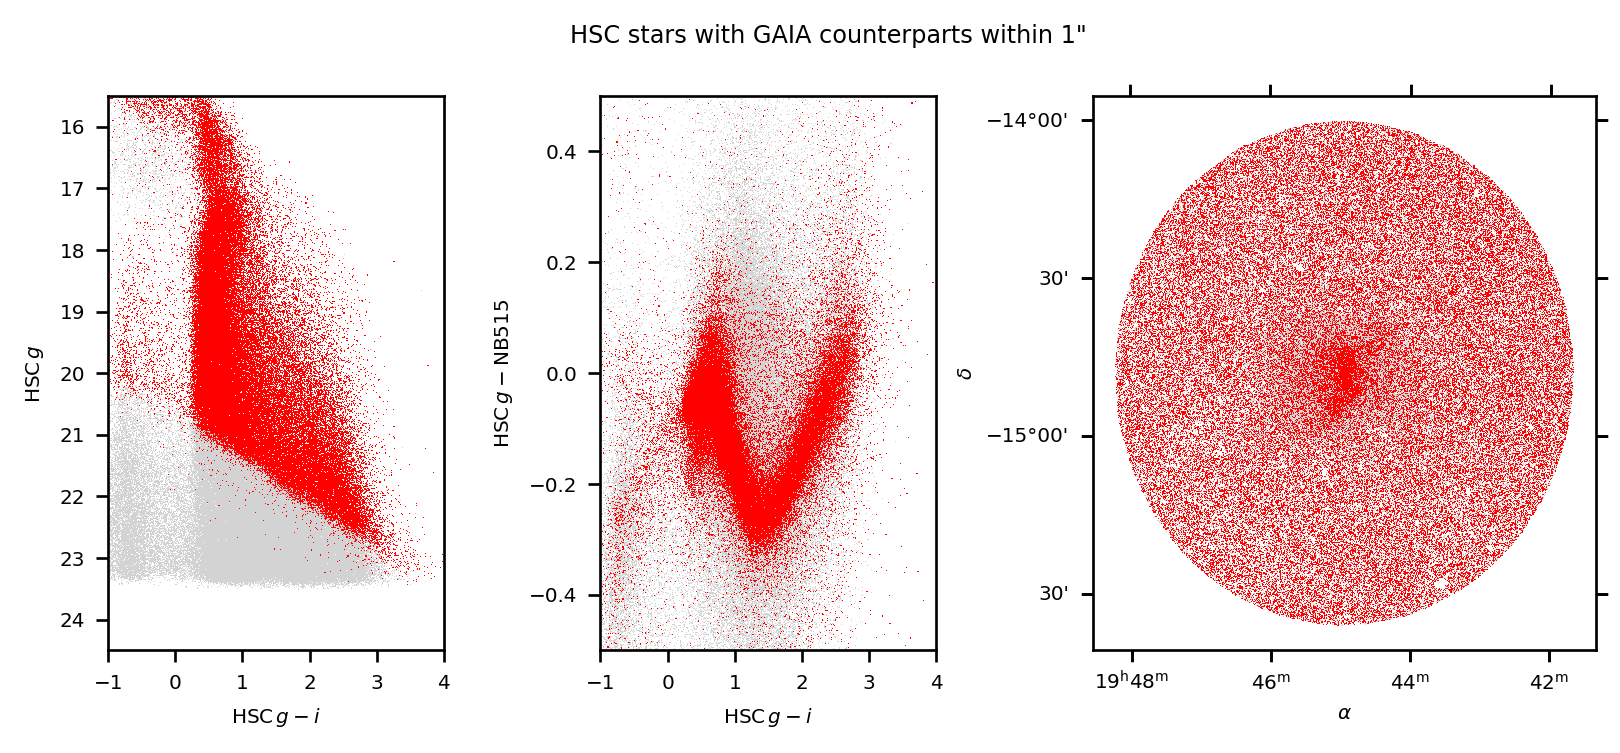

In [27]:
cmap = plt.get_cmap('viridis')

f = plt.figure(figsize=(8, 3), dpi=240)
gs = f.add_gridspec(1, 3, width_ratios=[2, 2, 3], wspace=0.4)   

ax = f.add_subplot(gs[0])
cmd.plot_observation(ax, obs, c='lightgray')
cmd.plot_observation(ax, obs, c='r', mask=hsc_gaia_mask, cmap=cmap)

ax = f.add_subplot(gs[1])
ccd.plot_observation(ax, obs, c='lightgray')
ccd.plot_observation(ax, obs, c='r', mask=hsc_gaia_mask, cmap=cmap)

ax = f.add_subplot(gs[2], projection=wcs.wcs)
fov.plot_observation(ax, obs, c='lightgray')
fov.plot_observation(ax, obs, c='r', mask=hsc_gaia_mask, cmap=cmap)

f.suptitle('HSC stars with GAIA counterparts within 1"')

## Merge Gaia proper motions into HSC catalog

In [28]:
# Cross-match HSC with GAIA
hsc_gaia_idx, separation = obs.cross_match(gaia)
print('median separation', np.median(separation.arcsec))
hsc_gaia_mask = (separation.arcsec < 1)

hsc_gaia_mask.shape, hsc_gaia_mask.sum()

median separation 3.237982364701124


((220202,), 93145)

In [29]:
gaia.data.columns

Index(['Dec', 'RA', 'SOURCE_ID', 'err_gaia_bp', 'err_gaia_g', 'err_gaia_rp',
       'err_parallax', 'err_pmdec', 'err_pmra', 'obs_gaia_bp', 'obs_gaia_g',
       'obs_gaia_rp', 'parallax', 'pm', 'pmdec', 'pmra'],
      dtype='object')

In [30]:
columns = ['parallax', 'pm', 'pmdec', 'pmra', 'err_parallax', 'err_pmdec', 'err_pmra']
obs.merge(gaia, hsc_gaia_idx, columns=columns, mask=hsc_gaia_mask)

In [31]:
obs.data.columns

Index(['objid', 'RA', 'Dec', 'X', 'Y', 'obs_hsc_i', 'obs_hsc_g',
       'obs_hsc_nb515', 'err_hsc_i', 'err_hsc_g', 'err_hsc_nb515', 'cli',
       'clg', 'cln', 'ext_hsc_g', 'ext_hsc_i', 'ext_hsc_nb515', 'parallax',
       'pm', 'pmdec', 'pmra', 'err_parallax', 'err_pmdec', 'err_pmra'],
      dtype='object')

## Assign probabilities

In [32]:
# Hard cuts on magnitudes

selection = galaxy.get_selection_mask(obs, nb=True) #, probcut=probcut)
obs.data.shape, selection.size, selection.sum()

((220202, 24), 220202, 37036)

In [33]:
# Look up membership probability

#galaxy.assign_probabilities(obs, pmap, mask=selection)
obs.data['p_member'] = 0
obs.data['p_member'][selection] = 1
(~np.isnan(obs.data['p_member'])).sum()

/tmp/ipykernel_180276/2972778437.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  obs.data['p_member'][selection] = 1
/tmp/ipykernel_180276/2972778437.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

220202

Text(0.5, 0.98, 'Stars selected by color cuts, colored by membersphip probability')

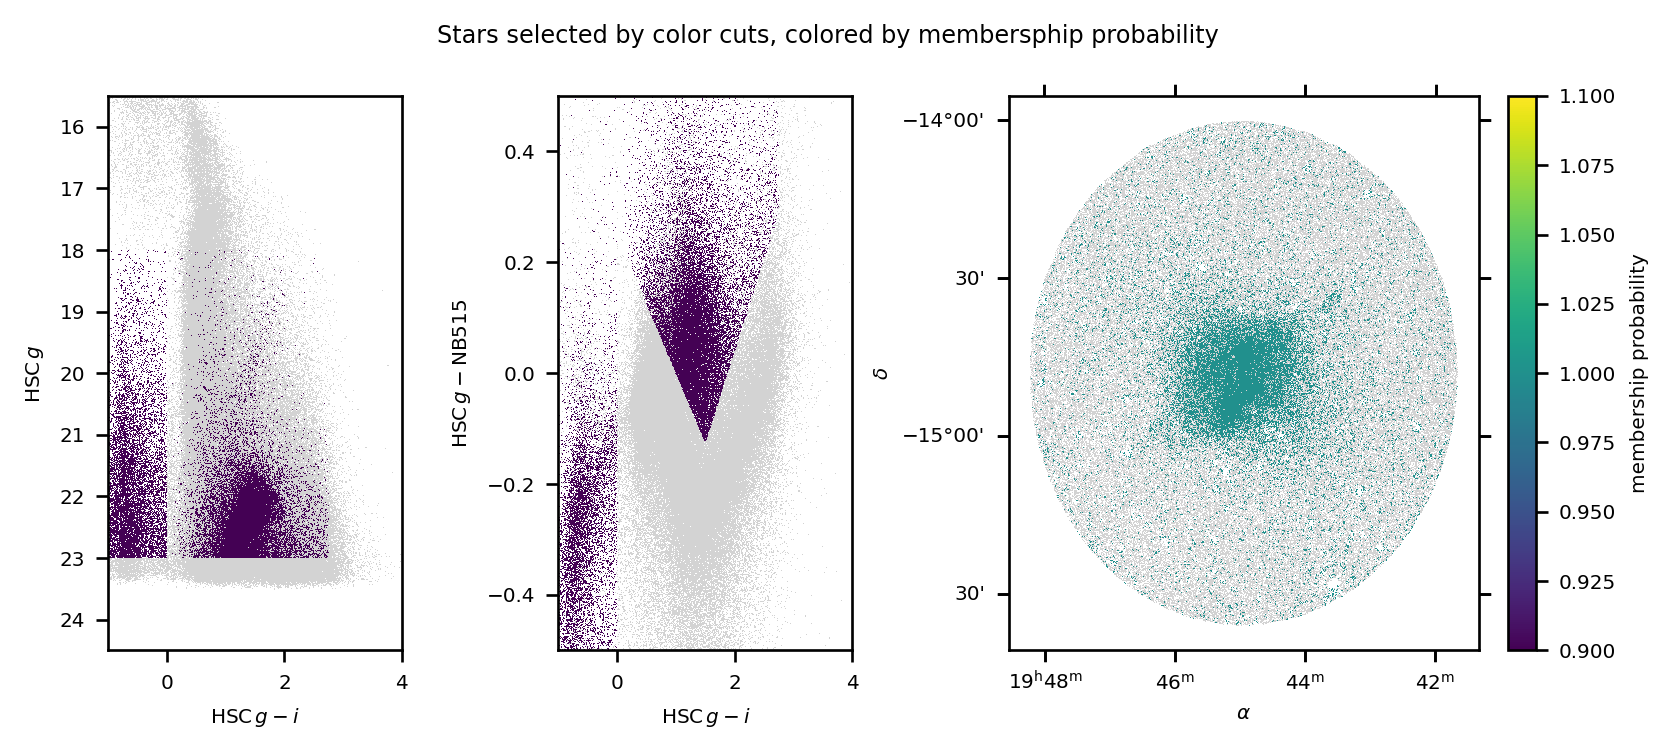

In [34]:
cmap = plt.get_cmap('viridis')

mask = selection & ~np.isnan(obs.data['p_member'])

f = plt.figure(figsize=(8, 3), dpi=240)
gs = f.add_gridspec(1, 3, width_ratios=[2, 2, 4], wspace=0.4)   

ax = f.add_subplot(gs[0])
cmd.plot_observation(ax, obs, c='lightgray')
cmd.plot_observation(ax, obs, c=obs.data['p_member'][mask], mask=mask, cmap=cmap)

ax = f.add_subplot(gs[1])
ccd.plot_observation(ax, obs, c='lightgray')
ccd.plot_observation(ax, obs, c=obs.data['p_member'][mask], mask=mask, cmap=cmap)

ax = f.add_subplot(gs[2], projection=wcs.wcs)
fov.plot_observation(ax, obs, c='lightgray')
l = fov.plot_observation(ax, obs, c=obs.data['p_member'][mask], mask=mask, cmap=cmap)

f.colorbar(l, ax=ax, label='membership probability')

f.suptitle('Stars selected by color cuts, colored by membersphip probability')

Text(0.5, 1.0, 'Distribution of membership probability')

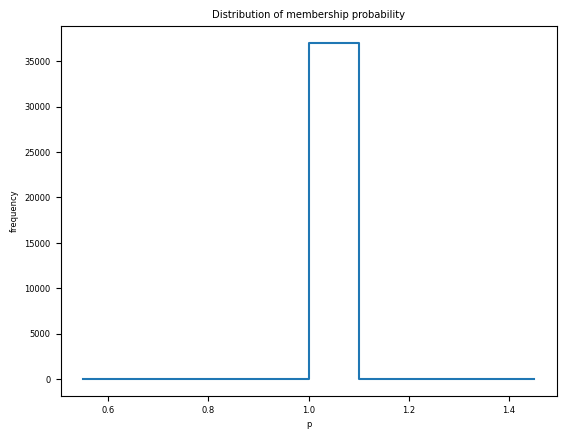

In [35]:
hist, bins = np.histogram(obs.data['p_member'][mask])
plt.step(0.5 * (bins[1:] + bins[:-1]), hist, where='mid')
plt.xlabel('p')
plt.ylabel('frequency')
plt.title('Distribution of membership probability')

## Assign priorities

In [36]:
# Calculate priorities and required exposure time
# This is implemented differently for every galaxy

galaxy.assign_priorities(obs, selection=selection, mask=None) # , mask=selection)
obs.data['priority'].unique()

/raid/pfs/ga_targeting/python/pfs/ga/targeting/targets/dsph/ngc6822.py:173: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  catalog.data['priority'][mask][keep] = priority[keep]
/raid/pfs/ga_targeting/python/pfs/ga/targeting/targets/dsph/ngc68

array([-1,  9,  4,  3,  8,  2,  6,  7,  5,  1,  0])

In [37]:
obs.data['exp_time']

0            NaN
1            NaN
2         7200.0
3            NaN
4         9000.0
           ...  
220197       NaN
220198    7200.0
220199    7200.0
220200    7200.0
220201    5400.0
Name: exp_time, Length: 220202, dtype: float64

Text(0.5, 0.98, 'Priority class')

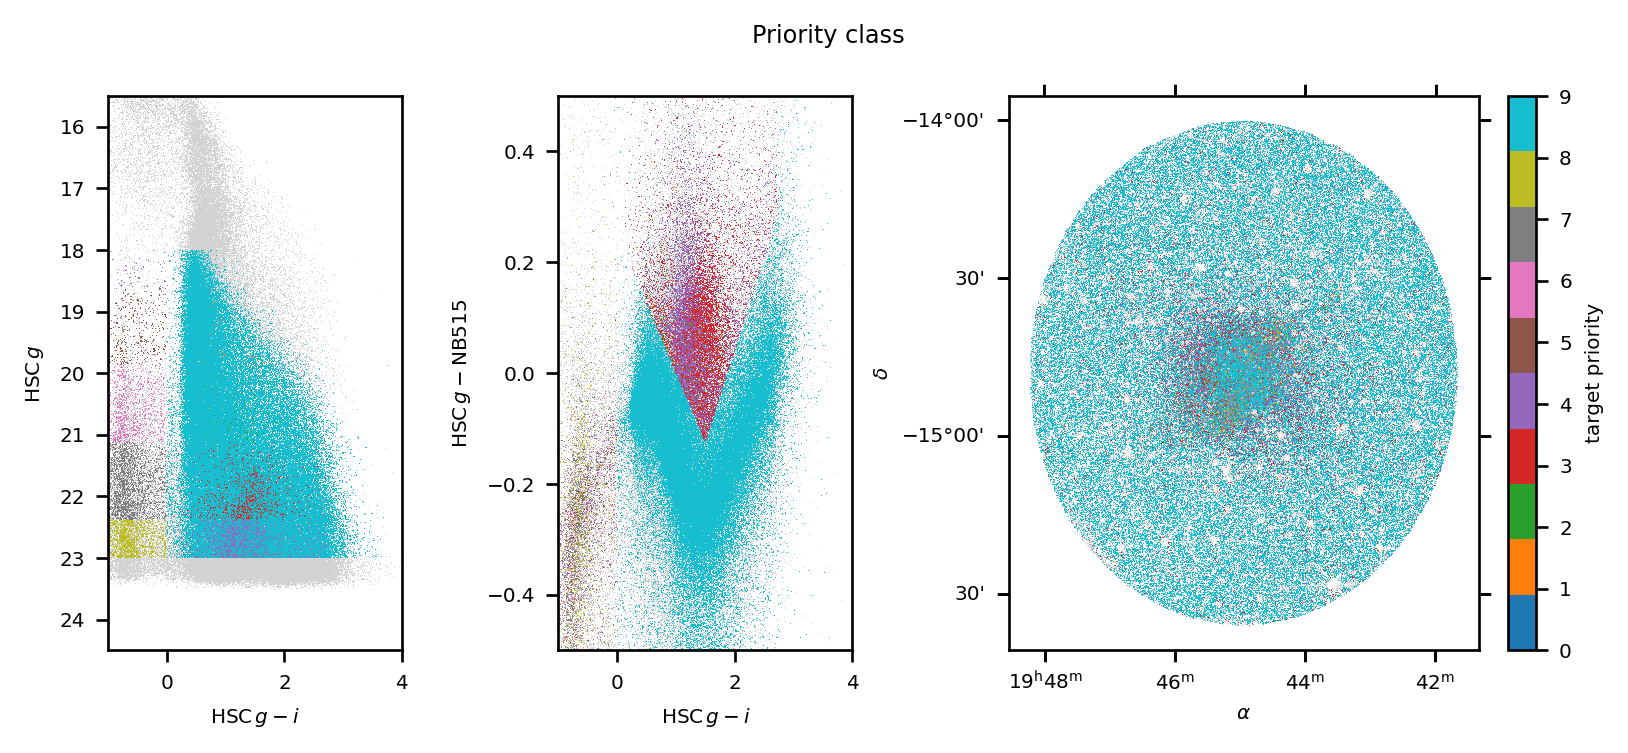

In [38]:
cmap = plt.get_cmap('tab10')

obs_mask = obs.data['priority'] >= 0

f = plt.figure(figsize=(8, 3), dpi=240)
gs = f.add_gridspec(1, 3, width_ratios=[2, 2, 4], wspace=0.4)   

ax = f.add_subplot(gs[0])
cmd.plot_observation(ax, obs, c='lightgray')
cmd.plot_observation(ax, obs, c=obs.data['priority'][obs_mask], mask=obs_mask, cmap=cmap)

ax = f.add_subplot(gs[1])
ccd.plot_observation(ax, obs, c='lightgray')
ccd.plot_observation(ax, obs, c=obs.data['priority'][obs_mask], mask=obs_mask, cmap=cmap)

ax = f.add_subplot(gs[2], projection=wcs.wcs)
fov.plot_observation(ax, obs, c='lightgray')
l = fov.plot_observation(ax, obs, c=obs.data['priority'][obs_mask], mask=obs_mask, cmap=cmap)

f.colorbar(l, ax=ax, label='target priority')

f.suptitle('Priority class')

In [39]:
obs_mask.size, obs_mask.sum()

(220202, 122174)

Text(0, 0.5, 'Target count')

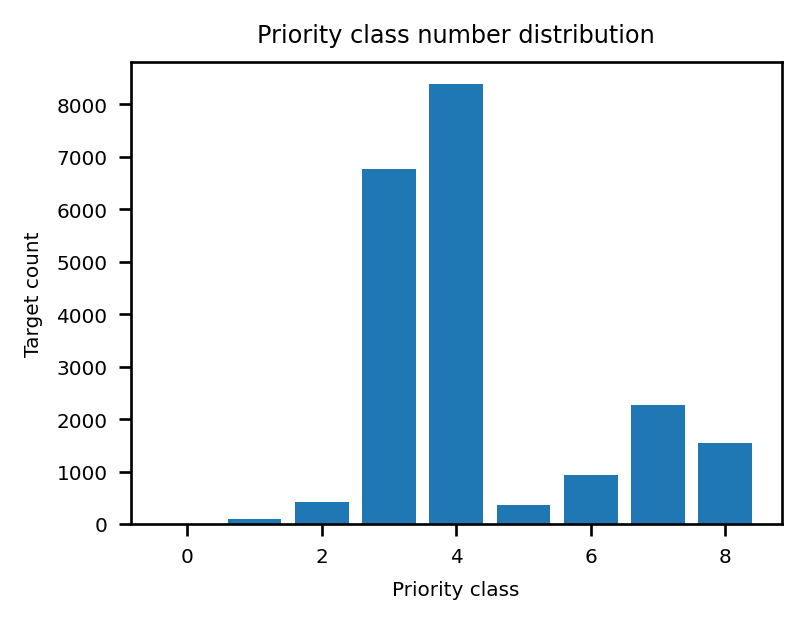

In [40]:
# Plot distribution of priorities

f, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=240)

hist = np.bincount(obs.data['priority'][obs_mask])
ax.bar(np.arange(hist.size - 1), hist[:-1])

# hist = np.bincount(obs.data['priority'][obs_assigned & (obs.data['priority'] >= 0) & (obs.data['priority'] < 9)])
# plt.bar(np.arange(hist.size), hist, color='r')


ax.set_title('Priority class number distribution')
ax.set_xlabel('Priority class')
ax.set_ylabel('Target count')


Text(0, 0.5, 'Target count')

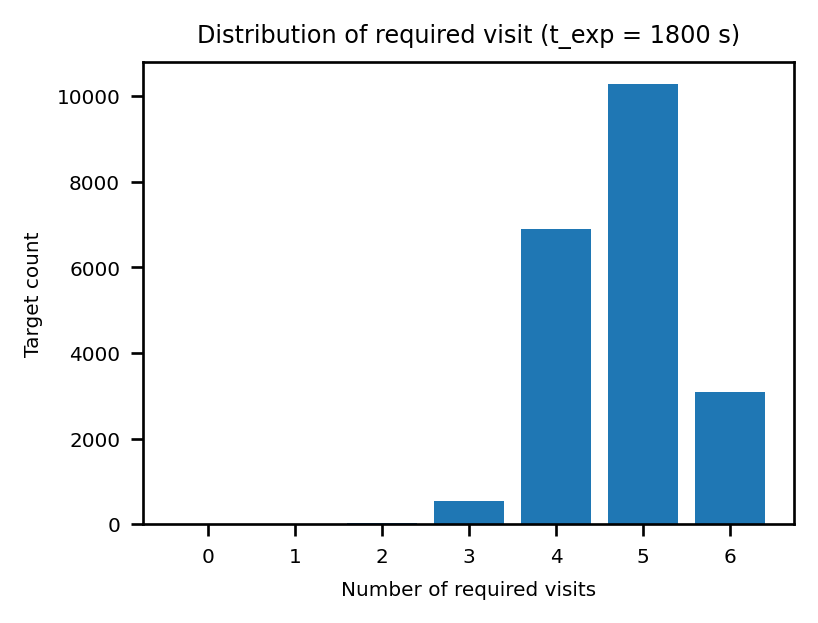

In [41]:
# Plot distribution of required visits

f, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=240)

hist = np.bincount((np.ceil(obs.data['exp_time'][obs_mask & (obs.data['priority'][obs_mask] < 9)] / 1800.0)).astype(int))
ax.bar(np.arange(hist.size), hist)

# hist = np.bincount(obs.data['priority'][obs_assigned & (obs.data['priority'] >= 0) & (obs.data['priority'] < 9)])
# plt.bar(np.arange(hist.size), hist, color='r')


ax.set_title('Distribution of required visit (t_exp = 1800 s)')
ax.set_xlabel('Number of required visits')
ax.set_ylabel('Target count')


In [42]:
# Save the catalog with p_member and priority

fn = os.path.join(OUTPUT_PATH, f'{GALAXY}_obs.feather')
print(fn)

s = DataFrameSerializer()
s.write(obs.data, fn)

/raid/pfs/user/enk/netflow/ngc6822_1_visit/ngc6822_obs.feather


In [43]:
obs.data.columns

Index(['objid', 'RA', 'Dec', 'X', 'Y', 'obs_hsc_i', 'obs_hsc_g',
       'obs_hsc_nb515', 'err_hsc_i', 'err_hsc_g', 'err_hsc_nb515', 'cli',
       'clg', 'cln', 'ext_hsc_g', 'ext_hsc_i', 'ext_hsc_nb515', 'parallax',
       'pm', 'pmdec', 'pmra', 'err_parallax', 'err_pmdec', 'err_pmra',
       'p_member', 'priority', 'exp_time'],
      dtype='object')

## Load sky and flux standards

In [44]:
from pfs.ga.targeting.io import FeatherSkyReader, FeatherFluxStdReader

In [45]:
r = FeatherSkyReader()
sky = r.read(SKY_FILE)
sky.data.shape

(128835, 6)

In [46]:
#r = FeatherFluxStdReader()
#fluxstd = r.read(FLUXSTD_FILE)
#fluxstd.data.shape

In [47]:
from pfs.ga.targeting.selection import MagnitudeSelection, ColorSelection
import copy

fstars = MagnitudeSelection(cmd.axes[1], 18, 20).apply(obs) & ColorSelection(cmd.axes[0], 0.09, 0.46).apply(obs) & (obs.data['cli'] <= 0.5) & (obs.data['clg'] <= 0.5)
fluxstd = copy.deepcopy(obs)
fluxstd._set_data(obs.get_data(mask=fstars))
fluxstd.data

,objid,RA,Dec,X,Y,obs_hsc_i,obs_hsc_g,obs_hsc_nb515,err_hsc_i,err_hsc_g,...,parallax,pm,pmdec,pmra,err_parallax,err_pmdec,err_pmra,p_member,priority,exp_time
9,346281739577,296.704859,-15.244466,10828.916710,10071.418608,19.615134,20.431754,20.393669,0.000737,0.000684,...,0.101181,9.364336,-8.809655,-3.175023,0.476618,0.425238,0.472300,0,9,5400.0
48,346281739826,296.702181,-15.234742,10883.866960,10279.938848,18.122720,18.816922,18.795698,0.000272,0.000278,...,0.200897,8.975739,-6.784266,5.876871,0.147337,0.138337,0.157811,0,9,3600.0
89,346281740133,296.708396,-15.221972,10754.768099,10553.321170,18.624569,19.423781,19.406725,0.000371,0.000373,...,0.052545,8.506331,-8.503106,0.234239,0.195279,0.191246,0.211794,0,9,5400.0
101,346281740160,296.743010,-15.219421,10038.882408,10606.388409,19.995533,20.684743,20.676680,0.000997,0.000749,...,-0.764634,8.237701,-7.719744,-2.874939,0.556951,0.562431,0.583812,0,9,7200.0
117,346281739868,296.698290,-15.214258,10963.423884,10719.091002,18.703446,19.477302,19.399812,0.000374,0.000420,...,0.198553,3.660393,-3.277554,1.629758,0.202421,0.199960,0.220985,0,9,5400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220165,311653566639,296.790913,-15.257507,9050.289356,9787.764839,19.146705,19.861400,19.791650,0.000507,0.000522,...,-0.031181,1.217523,0.867049,0.854745,0.270584,0.275357,0.308662,0,9,5400.0
220181,311653566729,296.763342,-15.253757,9620.150404,9869.546968,18.890419,19.567435,19.560627,0.000415,0.000423,...,0.010752,5.057817,-4.275371,-2.702353,0.246730,0.235089,0.259411,0,9,5400.0
220184,311653566640,296.789553,-15.252796,9078.159280,9888.801965,19.771067,20.439457,20.440209,0.000749,0.000714,...,0.383260,8.258247,-6.768901,-4.730817,0.472443,0.505771,0.557897,0,9,5400.0
220186,311653566739,296.778273,-15.252641,9311.370161,9892.718528,19.192637,19.999585,20.010554,0.000520,0.000554,...,0.042666,6.727458,-6.708375,-0.506350,0.288482,0.290371,0.318833,0,9,5400.0


Text(0.5, 1.0, 'Sky positions (count=128835)')

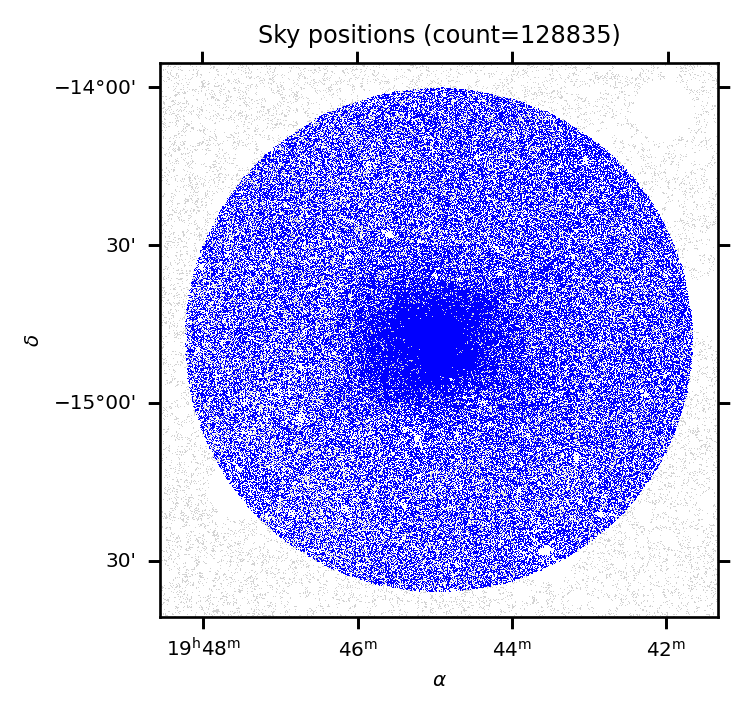

In [48]:
cmap = plt.get_cmap('tab10')

f = plt.figure(figsize=(3, 3), dpi=240)
gs = f.add_gridspec(1, 1)

ax = f.add_subplot(gs[0], projection=wcs.wcs)
fov.plot_observation(ax, obs, c='b')
fov.plot_observation(ax, sky, c='lightgray')

ax.set_title(f'Sky positions (count={len(sky)})')

# f.tight_layout()

Text(0.5, 1.0, 'Flux standards, count=4527')

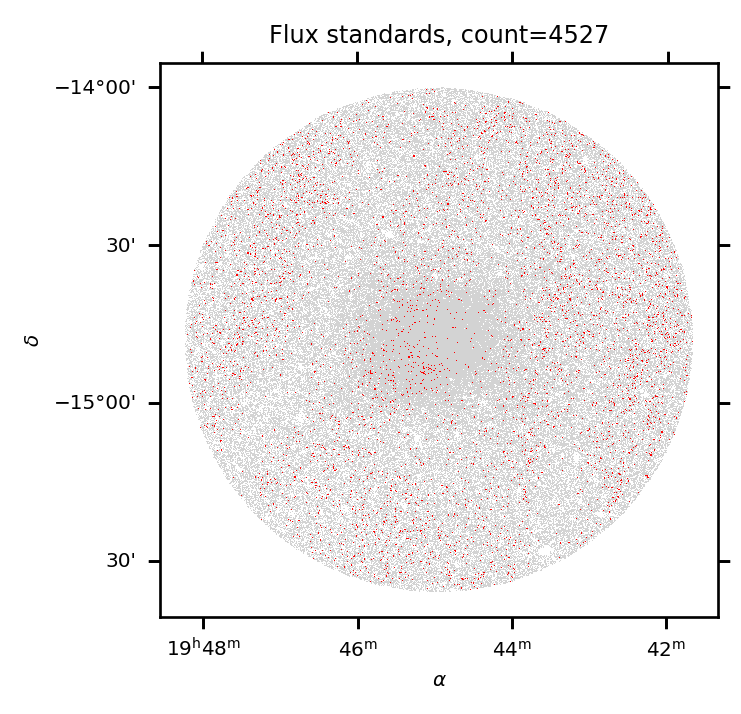

In [49]:
cmap = plt.get_cmap('tab10')

f = plt.figure(figsize=(3, 3), dpi=240)
gs = f.add_gridspec(1, 1)

ax = f.add_subplot(gs[0], projection=wcs.wcs)
fov.plot_observation(ax, obs, c='lightgray')
fov.plot_observation(ax, fluxstd, c='r')

ax.set_title(f'Flux standards, count={len(fluxstd)}')

# f.tight_layout()

# Define the netflow problem

In [50]:
# r = Angle(50, u.arcmin)

# Filter flux standards around pointing
# obs_mask = galaxy.get_selection_mask(obs, nb=True)
# obs_mask &= obs.cone_search(p.pos, r)
# obs_mask[obs_mask] &= (obs.data['priority'][obs_mask] >= 0) & \
#                       (obs.data['priority'][obs_mask] <= 9) & \
#                       ~np.isnan(obs.data['exp_time'][obs_mask])

print('obs_mask', obs_mask.size, obs_mask.sum())

obs_mask 220202 122174


In [51]:
# Reduce number of sky fibers
sky_mask = np.full(sky.shape, True)
# sky_mask = sky.cone_search(p.pos, r)
# sky_mask &= sky.random_sample(0.3)

print('sky_mask', sky_mask.size, sky_mask.sum())

sky_mask 128835 128835


In [52]:
# Filter flux standards around pointing
fluxstd_mask = np.full(fluxstd.shape, True)
# fluxstd_mask = fluxstd.cone_search(p.pos, r)

print('fluxstd_mask', fluxstd_mask.size, fluxstd_mask.sum())

fluxstd_mask 4527 4527


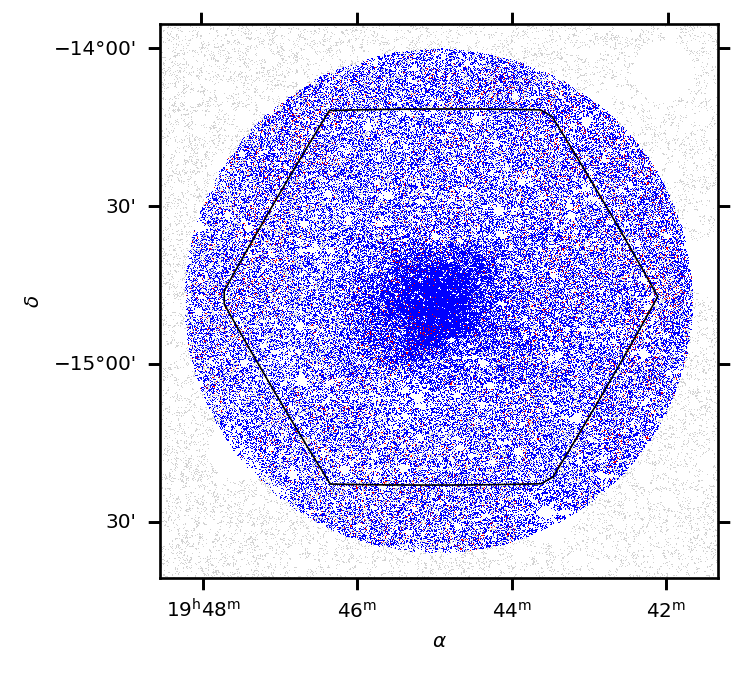

In [53]:
cmap = plt.get_cmap('tab10')

f = plt.figure(figsize=(3, 3), dpi=240)
gs = f.add_gridspec(1, 1)

ax = f.add_subplot(gs[0], projection=wcs.wcs)
# fov.plot_observation(ax, obs, c='lightgray')
fov.plot_observation(ax, obs, c='b', mask=obs_mask)
fov.plot_observation(ax, sky, c='lightgray', mask=sky_mask)
fov.plot_observation(ax, fluxstd, c='r', mask=fluxstd_mask)

for p in galaxy.get_pointings(SubaruPFI)[:]:
    SubaruPFI(SubaruWFC(p)).plot_focal_plane(ax, fov, corners=True)

# f.tight_layout()

In [54]:
ncobras = SubaruPFI().bench.cobras.nCobras
ncobras

2394

In [55]:
obs.data.columns

Index(['objid', 'RA', 'Dec', 'X', 'Y', 'obs_hsc_i', 'obs_hsc_g',
       'obs_hsc_nb515', 'err_hsc_i', 'err_hsc_g', 'err_hsc_nb515', 'cli',
       'clg', 'cln', 'ext_hsc_g', 'ext_hsc_i', 'ext_hsc_nb515', 'parallax',
       'pm', 'pmdec', 'pmra', 'err_parallax', 'err_pmdec', 'err_pmra',
       'p_member', 'priority', 'exp_time'],
      dtype='object')

In [56]:
# Construct the netflow problem

gurobi_options = dict(
    seed=0,                 # random seed
    presolve=2,             # agressiveness of presolve which tries to eliminate variables from the LP problem
    method=3,               # 3 means concurrent, 4 means deterministic concurrent
    degenmoves=0,           # degenerate simplex moves, set to 0 to prevent too much time to be spent on trying to improve the current solution
    heuristics=0.5,         # how much of the time to spend by performing heuristics
    mipfocus=1,             # mipfocus=1 is balanced toward finding more feasible solutions
                            # mipfocus=2 is balanced toward proving that the current solution is the best
                            # mipfocus=3 is to be used when the objection bound is moving very slowly
    mipgap=0.01,            # relative stopping criterion for bounds on the objective
    LogToConsole=1,         # 
    timelimit=300           # in sec
)

target_classes = {
    'sky': dict(
        prefix = 'sky',
        min_targets = 240,
        max_targets = 320,
        non_observation_cost = 0,
    ),
    'cal': dict(
        prefix = 'cal',
        min_targets = 40,
        max_targets = 240,
        non_observation_cost = 0,
        calib = True,
    ),
}
    
for i in range(10):
    target_classes[f'sci_P{i}'] = dict(
        prefix = 'sci',
        min_targets = None,
        max_targets = None,
        non_observation_cost = max(20 - 2 * i, 1),
        partial_observation_cost = 1e5,
    )

target_classes[f'sci_P0']['non_observation_cost'] = 1000
target_classes[f'sci_P1']['non_observation_cost'] = 500
target_classes[f'sci_P2']['non_observation_cost'] = 200
target_classes[f'sci_P3']['non_observation_cost'] = 100
target_classes[f'sci_P4']['non_observation_cost'] = 100
target_classes[f'sci_P5']['non_observation_cost'] = 100
target_classes[f'sci_P6']['non_observation_cost'] = 100
target_classes[f'sci_P7']['non_observation_cost'] = 50
target_classes[f'sci_P8']['non_observation_cost'] = 10
target_classes[f'sci_P9']['non_observation_cost'] = 0
    
########
    
cobra_groups = {
        'location': dict(
            groups = np.random.randint(4, size=ncobras),
            target_classes = [ 'sky' ],
            min_targets = 40,
            max_targets = 80,
            non_observation_cost = 10,
        ),
        'instrument': dict(
            groups = np.random.randint(4, size=ncobras),
            target_classes = [ 'sky' ],
            min_targets = 10,
            max_targets = 25,
            non_observation_cost = 10,
        )
    }

#######

netflow_options = dict(
    # Add a penalty if the target is too close to a black dot
    black_dot_penalty = None,
    # black_dot_penalty = lambda dist: 0,

    fiber_non_allocation_cost = 1e5,

    collision_distance = 2.0,
    elbow_collisions = True,
    # forbidden_targets = [
    #     43218108431
    # ],
    # forbidden_pairs = [
    #     [43486543901, 43218108431],
    # ],

    target_classes = target_classes,
    cobra_groups = cobra_groups,

    # time_budgets = {
    #     'science': dict(
    #         target_classes = [ 'sci_P0', 'sci_P1', 'sci_p2' ],
    #         budget = 5  # hr
    #     )
    # },

    # Do not penalize cobra moves with respect to cobra center
    cobra_move_cost = lambda dist: 0,

    num_reserved_fibers = 0,

    # This will only be used when netflow is rewritten to step-by-step fiber assignment
    # constrain_already_observed = False,

    # Allow more visits than minimally required
    allow_more_visits = True,

    epoch = 2016, # all catalogs must match
    ignore_proper_motion = True,

    # FPI configuration
    fiberids_path = f'{PREFIX}/pfs_utils/data/fiberids',

    # Generate full gurobi variable names instead of numbered ones (slow to build problem)
    use_named_variables = False,
)

debug_options = dict(
    ignoreEndpointCollisions = False,
    ignoreElbowCollisions = False,
    ignoreForbiddenPairs = False,
    ignoreForbiddenSingles = False,
    ignoreCalibTargetClassMinimum = False,
    ignoreCalibTargetClassMaximum = False,
    ignoreScienceTargetClassMinimum = False,
    ignoreScienceTargetClassMaximum = False,
    ignoreTimeBudget = False,
    ignoreCobraGroupMinimum = False,
    ignoreCobraGroupMaximum = False,
    ignoreReservedFibers = False,
)

pointings = []
exp_time = 12 / NVISITS * 900

# Observation time is the next day from now at midnight
obs_time = datetime(YEAR, MONTH, DAY, hour=0, minute=30, second=0, microsecond=0)+pd.Timedelta(hours=10)
obs_time = Time(obs_time)
print('obs_time', obs_time)

for p in galaxy.get_pointings(SubaruPFI)[:]:
    # Need to convert targeting.pointing to netflow.pointing
    pointings.append(Pointing(
        ra=p.ra,
        dec=p.dec,
        posang=p.posang,
        # obs_time=Time(datetime.now()),
        obs_time=obs_time,
        exp_time = exp_time,
        nvisits=NVISITS
    ))

nf = Netflow(f'{GALAXY}', pointings, workdir=OUTPUT_PATH,
             netflow_options=netflow_options,
             solver_options=gurobi_options,
             debug_options=debug_options)

# nf.append_science_targets(obs, mask=(obs.data['priority'] <= 9), exp_time=visits * p.exp_time)    ## All targets with priority
# nf.append_science_targets(obs, mask=(obs.data['priority'] <= 9))    ## All targets with priority
# nf.append_science_targets(obs, mask=obs_mask)    ## Only selected targets with priority
# nf.append_science_targets(obs, mask=obs_mask, exp_time=visits * p.exp_time)
# nf.append_science_targets(obs, mask=(obs.data['priority'] <= 9), exp_time=visits * p.exp_time)

nf.append_science_targets(obs, mask=obs_mask)
nf.append_sky_targets(sky, mask=sky_mask)
nf.append_fluxstd_targets(fluxstd, mask=fluxstd_mask)

len(nf.targets)

obs_time 2025-07-01 10:30:00


255536

In [57]:
# TODO: move this under unit tests

# Ignore some targets, this is to test the target index mappings
# This is for testing, do not access the target cache directly

nf._Netflow__calculate_exp_time()
nf._Netflow__calculate_target_visits()
nf._Netflow__cache_targets()

# Pick the first and last target that's inside the pointings
id1, id2 = nf._Netflow__target_cache.id[0], nf._Netflow__target_cache.id[-1]
print(id1, id2)

# Pick the first and last target
id3, id4 = nf._Netflow__targets.index[0], nf._Netflow__targets.index[-1]
print(id3, id4)

nf.netflow_options['forbidden_targets'] = [ id1, id2, id3, id4 ]
nf.netflow_options['forbidden_pairs'] = [ [ id1, id2 ], [ id3, id4 ] ]

nf._Netflow__targets.reset_index(names='id', inplace=True)

2755933264 1243124598831
2744870960 1277484336436


In [58]:
for c in nf.targets.columns:
    print(c, nf.targets[c].dtype)

id int64
RA float64
Dec float64
pm float64
pmra float64
pmdec float64
parallax float64
penalty int32
prefix object
exp_time float64
priority int64
class object
done_visits int64
req_visits int64


In [59]:
nf.targets

,id,RA,Dec,pm,pmra,pmdec,parallax,penalty,prefix,exp_time,priority,class,done_visits,req_visits
0,2744870960,295.570342,-16.442357,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0
1,2744870977,295.579120,-16.388088,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0
2,2744870986,295.424112,-16.389850,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0
3,2744870998,295.104394,-16.442821,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0
4,2744871003,295.692068,-16.388578,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255531,1277215901638,295.433036,-14.653356,NaN,NaN,NaN,NaN,0,sci,7200.0,9,sci_P9,0,1
255532,1277215901703,295.441153,-14.640435,1.524439,-0.946622,-1.194914,0.116044,0,sci,5400.0,9,sci_P9,0,1
255533,1277215901750,295.437131,-14.642476,7.158849,-7.046031,-1.265922,-0.111486,0,sci,5400.0,9,sci_P9,0,1
255534,1277484336108,295.438561,-14.637471,NaN,NaN,NaN,NaN,0,sci,9000.0,3,sci_P3,0,1


In [60]:
nf.targets[nf.targets['prefix'] == 'sky']

,id,RA,Dec,pm,pmra,pmdec,parallax,penalty,prefix,exp_time,priority,class,done_visits,req_visits
0,2744870960,295.570342,-16.442357,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0
1,2744870977,295.579120,-16.388088,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0
2,2744870986,295.424112,-16.389850,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0
3,2744870998,295.104394,-16.442821,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0
4,2744871003,295.692068,-16.388578,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128830,2778555486,297.298781,-13.305705,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0
128831,2778555491,297.109642,-13.039915,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0
128832,2778555499,297.117905,-13.081700,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0
128833,2778555508,297.396158,-13.170006,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0


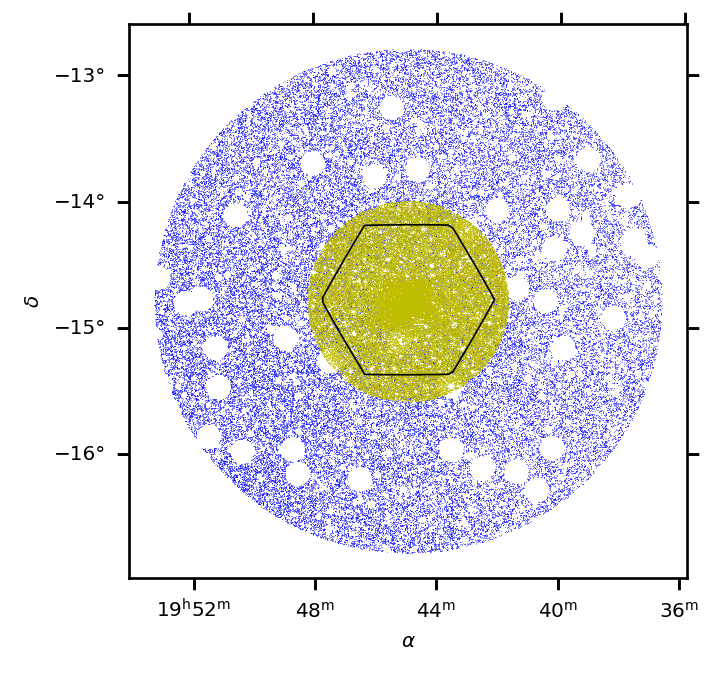

In [61]:
# Plot the final target list loaded into netflow
cmap = plt.get_cmap('tab10')

f = plt.figure(figsize=(3, 3), dpi=240)
gs = f.add_gridspec(1, 1)

ax = f.add_subplot(gs[0], projection=wcs.wcs)

mask = nf.targets['prefix'] == 'sky'
fov.plot(ax, nf.targets['RA'][mask], nf.targets['Dec'][mask], native_frame='world', c='b')
mask = nf.targets['prefix'] == 'cal'
fov.plot(ax, nf.targets['RA'][mask], nf.targets['Dec'][mask], native_frame='world', c='r')
mask = nf.targets['prefix'] == 'sci'
fov.plot(ax, nf.targets['RA'][mask], nf.targets['Dec'][mask], native_frame='world', c='y')


for p in galaxy.get_pointings(SubaruPFI)[:]:
    SubaruPFI(SubaruWFC(p)).plot_focal_plane(ax, fov, corners=True)

# f.tight_layout()

In [62]:
import cProfile
profiler = cProfile.Profile()
profiler.enable()

In [63]:
nf.build()

/raid/anaconda3/envs/pfs_ga/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/raid/anaconda3/envs/pfs_ga/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/raid/anaconda3/envs/pfs_ga/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 134834 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-15
Set parameter Presolve to value 2
Set parameter Method to value 3
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.5
Set parameter MIPFocus to value 1
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300


In [64]:
profiler.disable()

In [65]:
profiler.print_stats(sort='tottime')

         16064505 function calls (16053417 primitive calls) in 35.412 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1728583   13.655    0.000   13.655    0.000 gurobiproblem.py:93(add_linear_constraint)
   115346    4.343    0.000    4.917    0.000 Bench.py:444(distancesToLineSegments)
    103/9    2.848    0.028   35.403    3.934 base_events.py:1910(_run_once)
  1728583    1.936    0.000   15.764    0.000 netflow.py:1078(__add_constraint)
   102/89    1.651    0.016   42.429    0.477 selectors.py:451(select)
     2398    1.205    0.001    1.207    0.001 gurobiproblem.py:54(add_variable_array)
        1    0.952    0.952    1.359    1.359 netflow.py:641(__get_colliding_pairs)
     2394    0.905    0.000    0.912    0.000 TargetSelector.py:107(getTargetsInsidePatrolArea)
     2394    0.630    0.000    1.104    0.000 netflow.py:1367(__create_Tv_Cv_CG)
  1730991    0.451    0.000    0.719    0.000 netflow.py:1010(__make_na

In [66]:
nf.save_problem()

In [67]:
nf._Netflow__solver_options['timelimit'] = 900

In [68]:
nf.solve()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) W-2195 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 18 physical cores, 36 logical processors, using up to 18 threads

Optimize a model with 1728583 rows, 428118 columns and 4272797 nonzeros
Model fingerprint: 0x4705f336
Variable types: 1 continuous, 428117 integer (428105 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
Presolve removed 550009 rows and 289771 columns (presolve time = 5s) ...
Presolve removed 1477367 rows and 289771 columns
Presolve time: 5.69s
Presolved: 251216 rows, 138347 columns, 1249520 nonzeros
Variable types: 0 continuous, 138347 integer (138347 binary)
Found heuristic solution: objective 1186150.0000
Root relaxation presolve removed 5 rows and 2 columns
Root relaxation presolved: 2658 rows, 4886 columns, 11819 non

In [69]:
nf.save_solution()

In [70]:
nf.visits[0].visit_idx

0

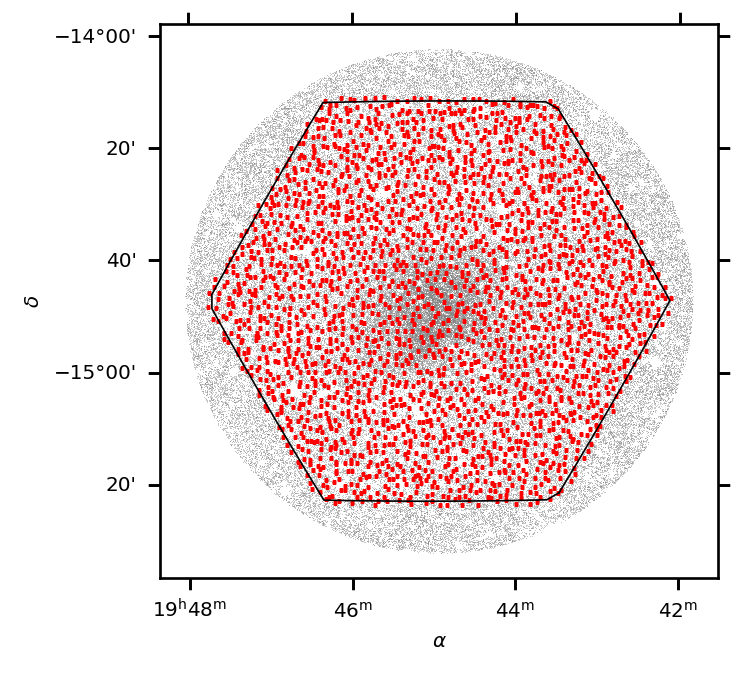

In [71]:
### This accesses internal variables, do not use this method to read the solution!

# Plot the final target list loaded into netflow
cmap = plt.get_cmap('tab10')

f = plt.figure(figsize=(3, 3), dpi=240)
gs = f.add_gridspec(1, 1)

ax = f.add_subplot(gs[0], projection=wcs.wcs)

ra = nf._Netflow__target_cache.ra
dec = nf._Netflow__target_cache.dec
fov.plot(ax, ra, dec, native_frame='world', c='gray')

for visit in nf.visits:
    tidx = np.array(list(nf._Netflow__target_assignments[visit.visit_idx].keys()))
    ra = nf._Netflow__target_cache.ra[tidx]
    dec = nf._Netflow__target_cache.dec[tidx]
    fov.plot(ax, ra, dec, native_frame='world', c='r', ms=1)

for p in galaxy.get_pointings(SubaruPFI)[:]:
    SubaruPFI(SubaruWFC(p)).plot_focal_plane(ax, fov, corners=True)
    # SubaruPFI(SubaruWFC(p)).plot_cobras(ax, fov, color='b')

# f.tight_layout()

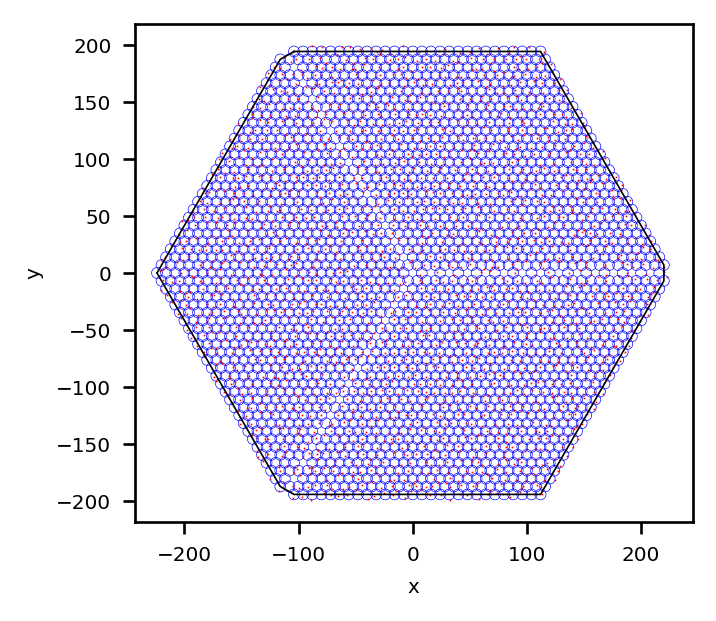

In [72]:
### This accesses internal variables, do not use this method to read the solution!

# Plot the final target list loaded into netflow
cmap = plt.get_cmap('tab10')

f = plt.figure(figsize=(3, 3), dpi=240)
gs = f.add_gridspec(1, 1)

ax = f.add_subplot(gs[0])

ra = nf._Netflow__target_cache.ra
dec = nf._Netflow__target_cache.dec
# fp.plot(ax, ra, dec, native_frame='world', c='gray')

for visit in nf.visits:
    tidx = np.array(list(nf._Netflow__target_assignments[visit.visit_idx].keys()))
    # Map target indices to target cache indices
    cache_map = np.where(nf._Netflow__target_mask[visit.visit_idx])[0]
    fp_map = nf._Netflow__cache_to_fp_pos_map[visit.visit_idx]

    # ra = nf._Netflow__target_cache.ra[tidx]
    # dec = nf._Netflow__target_cache.dec[tidx]

    p = nf._Netflow__target_fp_pos[visit.visit_idx][fp_map[tidx]]
    fp.plot(ax, p.real, p.imag, native_frame='pixel', c='r', ms=0.5)

    break

for p in galaxy.get_pointings(SubaruPFI)[:]:
    SubaruPFI(SubaruWFC(p)).plot_focal_plane(ax, fp, corners=True)
    SubaruPFI(SubaruWFC(p)).plot_cobras(ax, fp)

# f.tight_layout()

### Extract results

In [73]:
from pfs.ga.targeting.io import DataFrameSerializer

In [74]:
assignments = nf.get_target_assignments(include_target_columns=True,
                                        include_unassigned_fibers=True,
                                        include_engineering_fibers=True)

fn = os.path.join(OUTPUT_PATH, f'{GALAXY}_assignments.feather')
print(fn)

s = DataFrameSerializer()
s.write(assignments, fn)

for c in assignments.columns:
    print(c, assignments[c].dtype)

/raid/pfs/user/enk/netflow/ngc6822_1_visit/ngc6822_assignments.feather
targetid int64
pointing_idx int64
visit_idx int64
cobraid int64
fiberid int64
fp_x float64
fp_y float64
target_type int64
fiber_status int64
RA float64
Dec float64
pm float64
pmra float64
pmdec float64
parallax float64
penalty Int32
prefix object
exp_time float64
priority Int64
class object
done_visits Int64
req_visits Int64


In [75]:
assignments

,targetid,pointing_idx,visit_idx,cobraid,fiberid,fp_x,fp_y,target_type,fiber_status,RA,...,pmra,pmdec,parallax,penalty,prefix,exp_time,priority,class,done_visits,req_visits
0,-1,0,0,-1,1,NaN,NaN,5,1,NaN,...,NaN,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,<NA>,<NA>
1,-1,0,0,-1,45,NaN,NaN,5,1,NaN,...,NaN,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,<NA>,<NA>
2,-1,0,0,-1,92,NaN,NaN,5,1,NaN,...,NaN,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,<NA>,<NA>
3,-1,0,0,-1,137,NaN,NaN,5,1,NaN,...,NaN,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,<NA>,<NA>
4,-1,0,0,-1,184,NaN,NaN,5,1,NaN,...,NaN,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,2767169320,0,0,2390,377,115.426824,-181.722006,2,1,296.549281,...,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0
2497,455266535355,0,0,2391,378,112.317551,-187.102849,1,1,296.568634,...,NaN,NaN,NaN,0,sci,9000.0,4,sci_P4,0,1
2498,455266535256,0,0,2392,379,109.227494,-185.924291,1,1,296.570503,...,NaN,NaN,NaN,0,sci,7200.0,3,sci_P3,0,1
2499,455266535747,0,0,2393,380,113.413087,-193.389088,1,1,296.583533,...,NaN,NaN,NaN,0,sci,7200.0,3,sci_P3,0,1


In [76]:
mask = assignments['prefix'] == 'sky'
np.array(assignments['RA'][mask])

array([296.05959115, 295.99305382, 295.99323826, 295.94692476,
       295.91343915, 295.91692154, 296.09238148, 295.95933914,
       295.85903367, 295.91767971, 295.85297783, 296.12940375,
       296.08235964, 295.98144144, 295.87740014, 295.85309216,
       295.8211018 , 295.78362421, 296.05318851, 296.04304715,
       295.89899826, 295.85195246, 295.77737788, 295.77162808,
       295.75934942, 295.91714855, 295.74136974, 295.75111889,
       295.78896635, 295.7780132 , 295.77681254, 295.72063979,
       295.7158867 , 295.95289977, 295.8043762 , 295.76622715,
       295.90650518, 295.86300695, 295.7066381 , 295.67278793,
       295.66335031, 295.94120059, 295.8797699 , 295.71681819,
       295.66398616, 295.90783175, 295.92002995, 295.87805922,
       295.85364548, 295.82448131, 295.6351223 , 295.59977747,
       295.59324103, 295.90987337, 295.87526754, 295.71273727,
       295.71449982, 295.54299034, 295.56783193, 295.8601679 ,
       295.57264492, 295.53384134, 295.54415457, 296.17

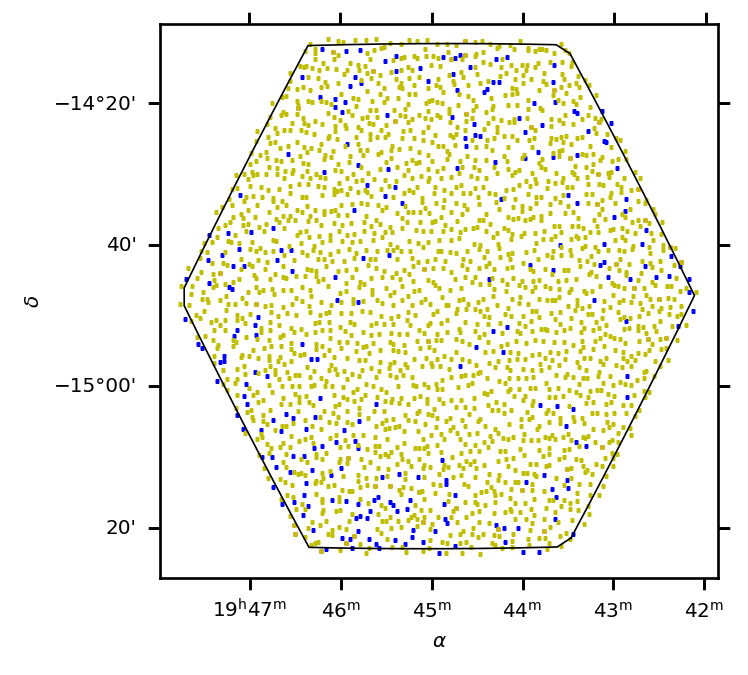

In [77]:
# Plot the final target list loaded into netflow
cmap = plt.get_cmap('tab10')

f = plt.figure(figsize=(3, 3), dpi=240)
gs = f.add_gridspec(1, 1)

ax = f.add_subplot(gs[0], projection=wcs.wcs)

mask = assignments['prefix'] == 'sky'
fov.plot(ax, assignments['RA'][mask], assignments['Dec'][mask], native_frame='world', c='b', ms=1)
mask = assignments['prefix'] == 'cal'
fov.plot(ax, assignments['RA'][mask], assignments['Dec'][mask], native_frame='world', c='r', ms=1)
mask = assignments['prefix'] == 'sci'
fov.plot(ax, assignments['RA'][mask], assignments['Dec'][mask], native_frame='world', c='y', ms=1)


for p in galaxy.get_pointings(SubaruPFI)[:]:
    SubaruPFI(SubaruWFC(p)).plot_focal_plane(ax, fov, corners=True)

# f.tight_layout()

In [78]:
summary = nf.get_target_assignment_summary()

fn = os.path.join(OUTPUT_PATH, f'{GALAXY}_summary.feather')
print(fn)

s = DataFrameSerializer()
s.write(summary.reset_index(), fn)

summary

/raid/pfs/user/enk/netflow/ngc6822_1_visit/ngc6822_summary.feather


,targetid,RA,Dec,pm,pmra,pmdec,parallax,penalty,prefix,exp_time,priority,class,done_visits,req_visits,num_visits
0,2744870960,295.570342,-16.442357,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0,0
1,2744870977,295.579120,-16.388088,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0,0
2,2744870986,295.424112,-16.389850,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0,0
3,2744870998,295.104394,-16.442821,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0,0
4,2744871003,295.692068,-16.388578,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255531,1277215901638,295.433036,-14.653356,NaN,NaN,NaN,NaN,0,sci,7200.0,9,sci_P9,0,1,0
255532,1277215901703,295.441153,-14.640435,1.524439,-0.946622,-1.194914,0.116044,0,sci,5400.0,9,sci_P9,0,1,0
255533,1277215901750,295.437131,-14.642476,7.158849,-7.046031,-1.265922,-0.111486,0,sci,5400.0,9,sci_P9,0,1,0
255534,1277484336108,295.438561,-14.637471,NaN,NaN,NaN,NaN,0,sci,9000.0,3,sci_P3,0,1,0


In [79]:
# All targets observed at least once
summary[summary['num_visits'] > 0]

,targetid,RA,Dec,pm,pmra,pmdec,parallax,penalty,prefix,exp_time,priority,class,done_visits,req_visits,num_visits
11730,2755933331,295.712737,-15.025712,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0,1
12330,2755933941,295.875268,-15.241526,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0,1
14024,2755935660,295.909873,-15.314725,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0,1
14649,2755936307,296.072135,-15.328856,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0,1
15237,2755936902,295.920030,-15.242262,NaN,NaN,NaN,NaN,0,sky,NaN,-1,sky,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250319,1173599815635,295.578769,-14.744960,NaN,NaN,NaN,NaN,0,sci,7200.0,3,sci_P3,0,1,1
250352,1173868250018,295.566577,-14.706458,5.507659,-1.225218,-5.369651,0.208875,0,cal,NaN,-1,cal,0,0,1
250373,1173868250103,295.584085,-14.715794,NaN,NaN,NaN,NaN,0,sci,7200.0,3,sci_P3,0,1,1
250463,1174136685619,295.583173,-14.675525,NaN,NaN,NaN,NaN,0,sci,9000.0,3,sci_P3,0,1,1


# Look at the ILP constraints to find any issues

In [80]:
model = nf._Netflow__problem._GurobiProblem__model
constrs = model.getConstrs()
len(constrs)

1728583

In [81]:
# Total number of constraints
len(nf._Netflow__constraints.all)

1728583

In [82]:
q = 0
for i in range(len(constrs)):
    name = constrs[i].ConstrName
    sense = constrs[i].Sense
    slack = constrs[i].Slack
    rhs = constrs[i].RHS

    #if slack == 0.0 and rhs > 1:
    if sense != '=' and rhs > 1:
        print(name, sense, rhs, slack)

        q += 1
        if q == 300:
            break

0x16b875 > 40.0 -0.0
0x16b876 < 240.0 200.0
0x16b878 > 240.0 -0.0
0x16b879 < 320.0 80.0
0x1a69ab > 40.0 -40.0
0x1a69ac < 80.0 0.0
0x1a69ad > 10.0 -15.0
0x1a69ae < 25.0 0.0


In [83]:
# Edges adding significant terms to the cost
# There shouldn't be any target sinks here, cause that would mean
# partially observed targets which we want to avoid

cost = nf._Netflow__problem._GurobiProblem__cost
n = cost.size()

print('total cost', cost.getValue())

for i in range(cost.size()):
    var = cost.getVar(i)
    name = var.VarName
    value = var.X
    coeff = cost.getCoeff(i)
    if value != 0 and coeff > 0:
        print(name, value, coeff, value * coeff)

total cost 1170540.0
0x1 4.0 500.0 2000.0
0x2 70.0 200.0 14000.0
0x3 4251.0 100.0 425100.0
0x4 5155.0 100.0 515500.0
0x5 293.0 100.0 29300.0
0x6 770.0 100.0 77000.0
0x7 1888.0 50.0 94400.0
0x8 1324.0 10.0 13240.0
